In [1]:
# -*- coding: utf-8 -*-
"""
Created on March 2025

@author: hwei
"""

import os
import gc
import logging
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import tensorflow as tf
import innvestigate
# This is required for innvestigate and must be called before models are loaded.
tf.compat.v1.disable_eager_execution()
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score, mean_squared_error
from keras import regularizers
from keras.models import Model
from keras.layers import Dense,LeakyReLU, Dropout, Add, Activation
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.model_selection import KFold
from tensorflow.keras.callbacks import Callback
from matplotlib.colors import Normalize
from sklearn.preprocessing import FunctionTransformer
tf.keras.utils.set_random_seed(0)
tf.config.list_physical_devices('GPU')
tf.compat.v1.disable_eager_execution()
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.engine.training_v1")
import xarray as xr
#import innvestigate
import scipy.io as sio
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from scipy.signal import butter, sosfilt
from tensorflow.keras.models import load_model

2025-10-19 01:43:53.134118: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-19 01:43:53.237039: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-19 01:43:53.269257: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [3]:
In_name = "TS_anom" #
Out_name = "TOA_anom" #


#====================== Here is 1D data ===============================#
# Paths to the datasets
# file_hist = "E:\\Yue\\CESM2\\test\\test.CESM2-historical.ens-mean.ANN.1850-2014.new.nc"
# file_2xCO2 = "E:\\Yue\\test\\test.2xCO2.ANN.new.nc"
# file_4xCO2 = "E:\\Yue\\CESM2\\test\\test.CESM2-4xCO2.ANN.nc"
'''
######### CESM1 #########
file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.historical.ens-mean.ANN.1920-2100.new.nc"
# file_2xCO2 = "/ocean/projects/ees240007p/hwei1/Yue/test/test.2xCO2.ANN.new.nc"
file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM1/test/test.4xCO2.ANN.new.nc"
######### CESM1 #########
'''
######### CESM2 #########
file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-historical.ens-mean.ANN.1850-2014.nc"
# file_2xCO2 = "/ocean/projects/ees240007p/hwei1/Yue/test/test.2xCO2.ANN.new.nc"
file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc"
######### CESM2 #########

#====================== End of 1D data ================================#

#====================== here is 2D data ===============================#

#====================== End of 1D data ================================#

# === Load historical data ===
ds_hist = xr.open_dataset(file_hist)
print("Historical dataset loaded:", ds_hist)

Historical dataset loaded: <xarray.Dataset>
Dimensions:   (time: 165, lon: 288, lat: 192)
Coordinates:
  * time      (time) object 1850-06-16 00:00:00 ... 2014-06-16 00:00:00
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Data variables:
    TS        (time, lat, lon) float32 ...
    TS_anom   (time, lat, lon) float64 ...
    TOA       (time) float64 ...
    TOA_anom  (time) float64 ...
Attributes:
    ERF:      ERF = F - F_ctrl (from Isla's ERFMIP runs)
    script:   /glade/work/dongy24/Python/create_input_for_huaiyu_CESM2.ipynb
    author:   Y. Dong, 04/02/2025


In [4]:
lat = ds_hist["lat"]
lon = ds_hist["lon"]

time_hist = ds_hist["time"] 

######### CESM2 #########
time_hist = [date.year for date in time_hist.values] #for C2 data
######### CESM2 #########

######### CESM1 #########
#time_hist = time_hist.values #for C1 data
######### CESM1 #########

TS_hist = ds_hist[In_name]
TOA_hist = ds_hist[Out_name].values

# === Load 2xCO2 data ===
# ds_2xCO2 = xr.open_dataset(file_2xCO2)
# print("2xCO2 dataset loaded:", ds_2xCO2)

# time_2xCO2 = ds_2xCO2["year"]
# TS_2xCO2 = ds_2xCO2[In_name]
# TOA_2xCO2 = ds_2xCO2[Out_name].values

# === Load 4xCO2 data ===
ds_4xCO2 = xr.open_dataset(file_4xCO2)
print("4xCO2 dataset loaded:", ds_4xCO2)


# time_4xCO2_coords = ds_4xCO2["year"]
# time_4xCO2 = time_4xCO2_coords.values


######### CESM2 #########
time_4xCO2 = ds_4xCO2["time"] 
time_4xCO2 = [date.year for date in time_4xCO2.values] #for C2 data
######### CESM2 #########
'''
######### CESM1 #########
time_4xCO2 = ds_4xCO2["year"] 
time_4xCO2 = time_4xCO2.values #C1 data
######### CESM1 #########
'''

TS_4xCO2 = ds_4xCO2[In_name]
TOA_4xCO2 = ds_4xCO2[Out_name].values

# Optional: Print shapes to verify
print("TS_hist shape:", TS_hist.shape)
# print("TS_2xCO2 shape:", TS_2xCO2.shape)
print("TS_4xCO2 shape:", TS_4xCO2.shape)

4xCO2 dataset loaded: <xarray.Dataset>
Dimensions:   (time: 150, lon: 288, lat: 192)
Coordinates:
  * time      (time) object 0001-06-16 00:00:00 ... 0150-06-16 00:00:00
  * lon       (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat       (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
Data variables:
    TS        (time, lat, lon) float32 ...
    TS_anom   (time, lat, lon) float32 ...
    TOA       (time) float64 ...
    TOA_anom  (time) float64 ...
Attributes:
    script:   /glade/work/dongy24/Python/create_input_for_huaiyu_CESM2.ipynb
TS_hist shape: (165, 192, 288)
TS_4xCO2 shape: (150, 192, 288)


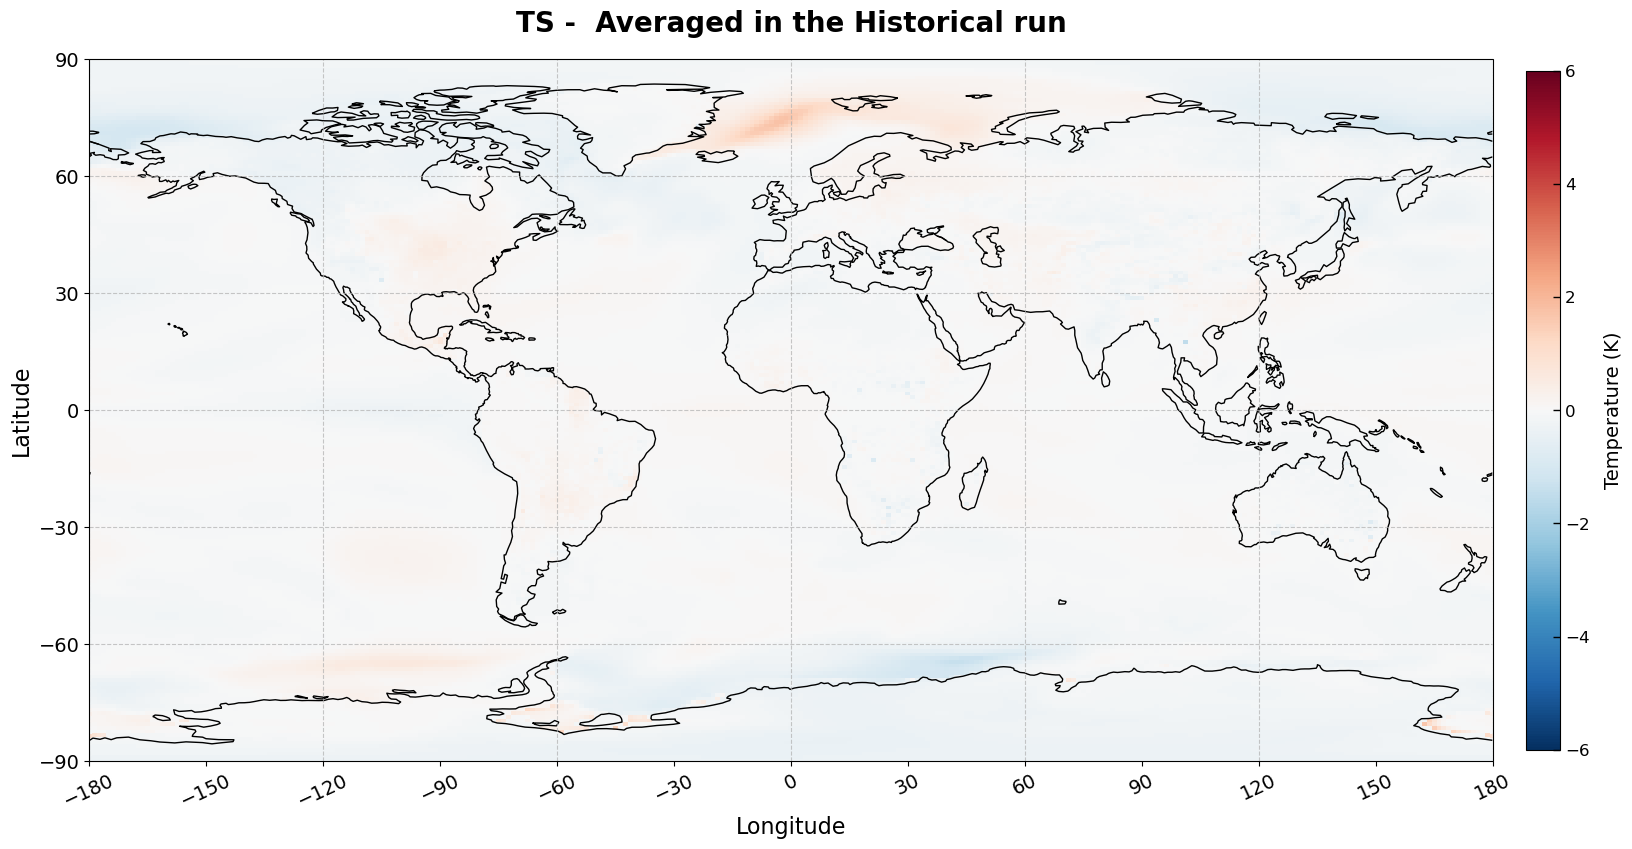

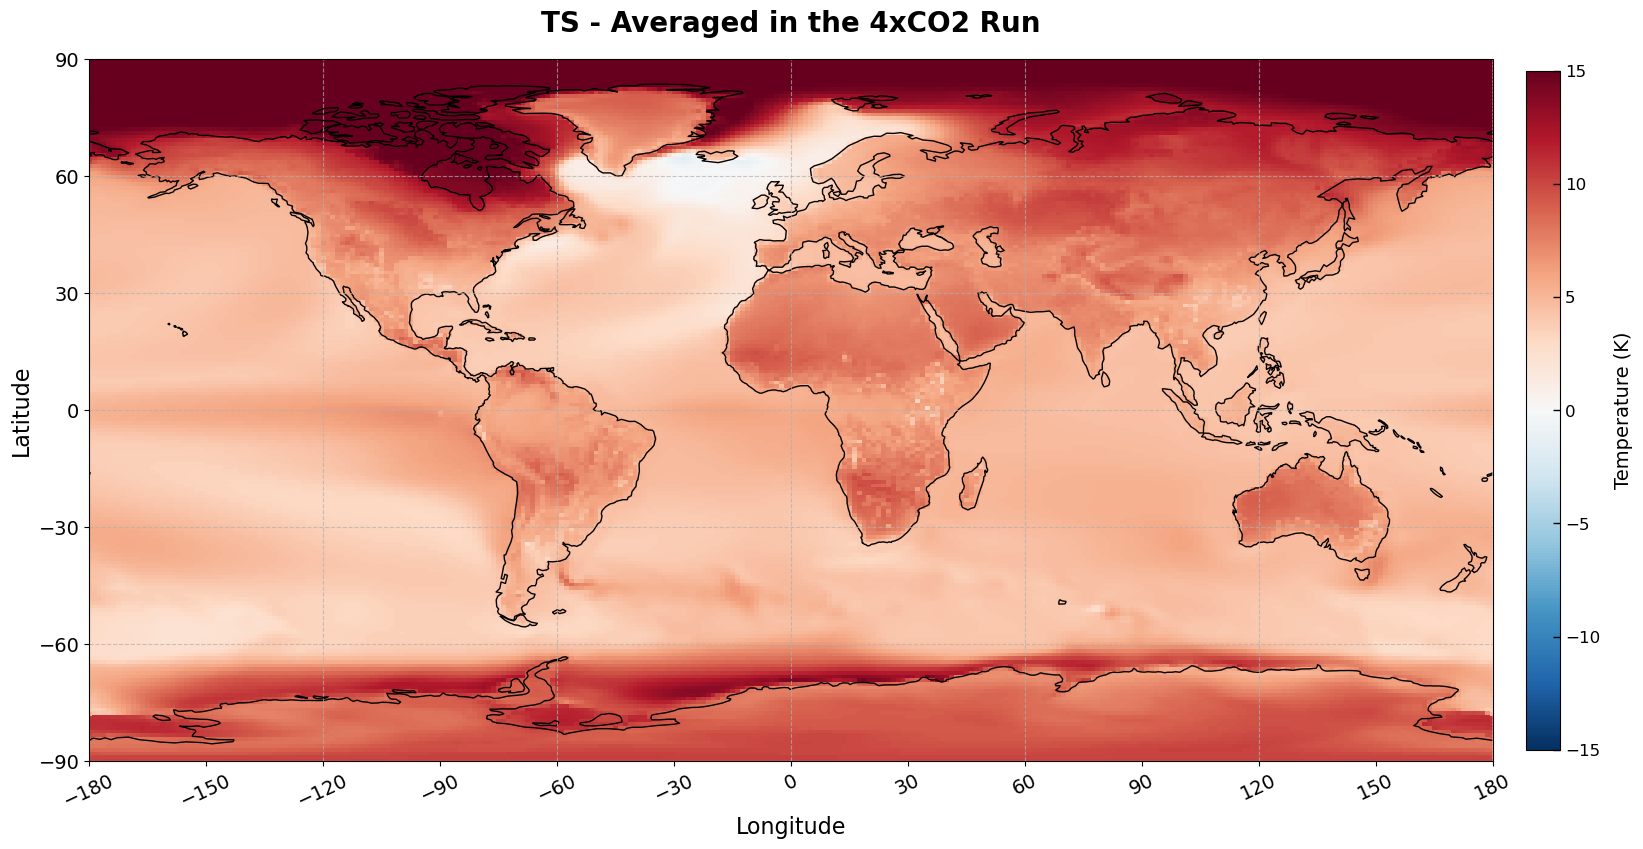

In [5]:
def plot_global_map(lon, lat, data2d, title, cbar_label="Temperature (K)", cmap="RdBu_r", vmin=None, vmax=None):
    """
    Plot a 2D global map using Cartopy with enhanced styling and colorbar.

    Parameters:
        lon (array): Longitudes
        lat (array): Latitudes
        data2d (2D array): Data to plot (must match lat/lon)
        title (str): Plot title
        cbar_label (str): Colorbar label
        cmap (str): Colormap
        vmin, vmax (float): Optional color scale limits
    """
    fig = plt.figure(figsize=(18, 9))
    ax = plt.axes(projection=ccrs.PlateCarree())

    # Plot the data
    pcm = ax.pcolormesh(lon, lat, data2d, cmap=cmap, transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax)

    # Add colorbar
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.02, shrink=0.8)
    cbar.set_label(cbar_label, fontsize=14, labelpad=10)
    cbar.ax.tick_params(labelsize=12, direction='in', length=5, width=1)

    # Coastlines and grid
    ax.coastlines(resolution="110m", linewidth=1)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.right_labels = False
    gl.top_labels = False
    gl.left_labels = False
    gl.bottom_labels = False
    gl.xformatter = LongitudeFormatter()
    gl.yformatter = LatitudeFormatter()
    gl.xlabel_style = {"size": 13}
    gl.ylabel_style = {"size": 13}

    # Axis ticks
    ax.set_xticks(range(-180, 181, 30), crs=ccrs.PlateCarree())
    ax.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
    ax.tick_params(axis="both", which="major", labelsize=14)
    plt.xticks(rotation=25, ha="center")

    # Title and labels
    ax.set_title(title, fontsize=20, fontweight="bold", pad=20)
    ax.set_xlabel("Longitude", fontsize=16)
    ax.set_ylabel("Latitude", fontsize=16)

    plt.tight_layout()
    plt.show()





# Historical mean TS
plot_global_map(
    lon=lon,
    lat=lat,
    # data2d=np.mean(ds_hist[In_name], axis=0),
    data2d=ds_hist[In_name][0,:,:],
    title="TS -  Averaged in the Historical run",
    vmin=-6, vmax=6
)

# 2xCO2 mean TS
# plot_global_map(
#     lon=lon,
#     lat=lat,
#     data2d=np.mean(ds_2xCO2[In_name], axis=0),
#     title="TS - Averaged in the 2xCO2 Run",
#     vmin=-12, vmax=12
# )


# 4xCO2 mean TS
plot_global_map(
    lon=lon,
    lat=lat,
    data2d=np.mean(ds_4xCO2[In_name], axis=0),
    title="TS - Averaged in the 4xCO2 Run",
    vmin=-15, vmax=15
)



In [6]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
from scipy import stats
from scipy import ndimage # New import for spatial smoothing
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def calculate_trend_and_significance_temporal_smooth(relevance_data, time_axis, p_value_threshold=0.05, window_size=5):
    """
    Applies temporal smoothing (running mean) to relevance time series before
    calculating the linear trend and significance.
    'window_size' is the number of years for the running mean.
    """
    if relevance_data.ndim != 3:
        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")
    if time_axis.ndim != 1 or time_axis.shape[0] != relevance_data.shape[0]:
        raise ValueError("Time axis must be 1D and match the time dimension of data.")

    num_time, lat_dim, lon_dim = relevance_data.shape
    trend_map = np.full((lat_dim, lon_dim), np.nan)
    significance_mask = np.full((lat_dim, lon_dim), False, dtype=bool)

    print(f"    Calculating trends with temporal smoothing (window={window_size}) for {lat_dim}x{lon_dim} grid...")
    for y in range(lat_dim):
        for x in range(lon_dim):
            relevance_timeseries = relevance_data[:, y, x]
            
            if np.all(np.isfinite(relevance_timeseries)):
                # Apply temporal smoothing using a rolling mean
                # Using pandas for convenient rolling mean with handling of edges
                series = pd.Series(relevance_timeseries)
                smoothed_timeseries = series.rolling(window=window_size, center=True, min_periods=1).mean().to_numpy()
                
                # Filter out NaNs that might be introduced by rolling mean if window is large
                valid_indices = ~np.isnan(smoothed_timeseries)
                
                if np.sum(valid_indices) > 1: # Need at least 2 points for regression
                    current_time_axis = time_axis[valid_indices]
                    current_data = smoothed_timeseries[valid_indices]
                    
                    if len(current_data) > 1: # Still need at least 2 points after NaN removal
                        lin_reg_result = stats.linregress(x=current_time_axis, y=current_data)
                        trend_map[y, x] = lin_reg_result.slope
                        if lin_reg_result.pvalue < p_value_threshold:
                            significance_mask[y, x] = True
    print("    Trend and significance calculation with temporal smoothing complete.")
    return trend_map, significance_mask

def calculate_trend_and_significance(relevance_data, time_axis, p_value_threshold=0.1):
    """
    Calculates the linear trend (slope) and a significance mask
    at each grid cell over time.
    """
    if relevance_data.ndim != 3:
        raise ValueError("Input relevance_data must be a 3D array [time, lat, lon].")
    if time_axis.ndim != 1 or time_axis.shape[0] != relevance_data.shape[0]:
        raise ValueError("Time axis must be 1D and match the time dimension of data.")

    _, lat_dim, lon_dim = relevance_data.shape
    trend_map = np.full((lat_dim, lon_dim), np.nan)
    significance_mask = np.full((lat_dim, lon_dim), False, dtype=bool) # Mask for significance

    print(f"    Calculating trends and significance for {lat_dim}x{lon_dim} grid...")
    for y in range(lat_dim):
        for x in range(lon_dim):
            relevance_timeseries = relevance_data[:, y, x]
            if np.all(np.isfinite(relevance_timeseries)) and len(relevance_timeseries) > 1:
                lin_reg_result = stats.linregress(x=time_axis, y=relevance_timeseries)
                trend_map[y, x] = lin_reg_result.slope
                if lin_reg_result.pvalue < p_value_threshold:
                    significance_mask[y, x] = True
    print("    Trend and significance calculation complete.")
    return trend_map, significance_mask

def apply_spatial_smoothing(data2d, sigma=1):
    """
    Applies a Gaussian filter to smooth a 2D map.
    Sigma is the standard deviation for Gaussian kernel.
    """
    print(f"    Applying spatial smoothing with sigma={sigma}...")
    smoothed_map = ndimage.gaussian_filter(data2d, sigma=sigma)
    print("    Smoothing complete.")
    return smoothed_map

In [7]:
ds_hist[In_name][0,:,:]

<xarray.DataArray 'TS_anom' (lat: 192, lon: 288)>
[55296 values with dtype=float64]
Coordinates:
    time     object 1850-06-16 00:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Attributes:
    units:    K
    note:     TS_anom = TS_his - TS_ref
    ref:      B1850 yr1001-2000 mean

In [8]:
### load the mean and STD calculated in the Pre-industrial control run for normalization

# Paths to the datasets and trained model


########### CESM1 Model ##########
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom" #original model

#new model(1) -wrong one
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data2/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom" #wrong place but the model is for data 1

#corrected one model with best result so far
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_model_Gelu/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom"

#linear model C1
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM1/trained_linear/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_linear+linear/TOA_anom/'

#change Gelu C1
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM1/Gelu_only/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+elu/TOA_anom'
#change PRelu C1
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM1/Prelu_only/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+PRelu/TOA_anom/'
######### CESM1 #########

########## CESM2 Model ######
#==================data1=================
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom"

#data1 model(1) gelu   Correct
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data1_Gelu/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom"

#data 1 linear
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_linear(1)/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_linear+linear/TOA_anom"
#data 1 only changed Gelu
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/Gelu_data1)/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+elu/TOA_anom/'
#data 1 changed PRelu for 2nd layer
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/PRelu_data1/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+PRelu/TOA_anom/'

#===================data2================== 
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data2/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+elu/TOA_anom"

#model gelu
#path_PIc = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data2_Gelu/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom" 

path_PIc = "/ocean/projects/ees250004p/ezhu3/MIROC6/trained_model/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom"
#data 2 linear
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_linear(2)/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_linear+linear/TOA_anom'
#data 2 only change Gelu for 1st layer
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_model_data2_Gelu/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/TOA_anom/'
#data 2 only change PRelu for 2nd layer
#path_PIc = '/ocean/projects/ees250004p/ezhu3/data/CESM2/PRelu_data2/NeuralNet/CNN_DivideSTD_Neur32x32_BS32_5foldCV_Reg0Drop0.25_relu+PRelu/TOA_anom'

######### CESM2 #########

normalization= sio.loadmat(os.path.join(path_PIc, 'Normalization.mat'))

X_mean = normalization['X_mean']
X_std = normalization['X_std']
y_mean = normalization['y_mean']
y_std = normalization['y_std']


TS_hist_norm = (TS_hist-X_mean)/X_std.squeeze()
# TS_2xCO2_norm = (TS_2xCO2-X_mean)/X_std.squeeze()
TS_4xCO2_norm = (TS_4xCO2-X_mean)/X_std.squeeze()

TS_hist_norm = TS_hist_norm.values[..., tf.newaxis]
# TS_2xCO2_norm = TS_2xCO2_norm.values[..., tf.newaxis]
TS_4xCO2_norm = TS_4xCO2_norm.values[..., tf.newaxis]

print(X_mean)
print(X_std)

ValueError: operands could not be broadcast together with shapes (165,192,288) (128,256) 

In [ ]:
from tensorflow.keras import backend as K
# load the neural network trained from Pre-industrial control simulation

n_folds = 5
n_ensembles = 1

pred_hist_ALL = np.empty((TOA_hist.shape[0],0))
# pred_2xCO2_ALL = np.empty((TOA_2xCO2.shape[0],0))
pred_4xCO2_ALL = np.empty((TOA_4xCO2.shape[0],0))


for fold_no in range(1,n_folds+1):

    pred_hist = np.zeros((TOA_hist.shape[0],1));
    # pred_2xCO2 = np.zeros((TOA_2xCO2.shape[0],1));
    pred_4xCO2 = np.zeros((TOA_4xCO2.shape[0],1));
    for ens_no in range(1,n_ensembles+1):
        K.clear_session() # Clears the Keras session and TensorFlow graph
        gc.collect()  
        Model = load_model(os.path.join(path_PIc,'model_fold'+str(fold_no)+'_ens'+str(ens_no)+'.h5'))
        pred_hist = pred_hist+ Model.predict(TS_hist_norm, batch_size=1)
        # pred_2xCO2 = pred_2xCO2+ Model.predict(TS_2xCO2_norm)
        pred_4xCO2 = pred_4xCO2+ Model.predict(TS_4xCO2_norm)
        
    pred_hist = pred_hist/n_ensembles
    # pred_2xCO2 = pred_2xCO2/n_ensembles
    pred_4xCO2 = pred_4xCO2/n_ensembles


# re-scale the prediction from the neural network
    pred_hist = pred_hist*y_std + y_mean
    # pred_2xCO2 = pred_2xCO2*y_std + y_mean
    pred_4xCO2 = pred_4xCO2*y_std + y_mean



    pred_hist_ALL = np.concatenate(( pred_hist_ALL,pred_hist),axis = 1)
    # pred_2xCO2_ALL = np.concatenate(( pred_2xCO2_ALL,pred_2xCO2),axis = 1)
    pred_4xCO2_ALL = np.concatenate(( pred_4xCO2_ALL,pred_4xCO2),axis = 1)




In [ ]:
def plot_predictions(time, truth, preds, title):
    """
    Plots the ground truth, mean prediction, and individual model predictions with transparency.

    Parameters:
        time (array-like): Time axis values.
        truth (array-like): Ground truth values.
        preds (2D array): Predictions from ensemble or multiple models (shape: time x ensemble).
        title (str): Title of the plot.
    """
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot truth
    ax.plot(time, truth, label="Truth", color="C0", linewidth=2)

    # Plot mean prediction
    mean_pred = np.mean(preds, axis=1)
    ax.plot(time, mean_pred, label="Prediction (Mean)", color="C1", linewidth=1.8)

    # Plot individual models
    for i in range(preds.shape[1]):
        ax.plot(time, preds[:, i], linewidth=1, alpha=0.5,
                label="Prediction (CV" + str(i+1) + ")")

    # Style
    ax.set_xlabel("Time (Year)", fontsize=16)
    ax.set_ylabel(Out_name, fontsize=16)
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_title(title, fontsize=18, pad=15)
    ax.legend(fontsize=14, loc="best")

    # R² annotation
    r2 = r2_score(truth, mean_pred)
    ax.text(0.02, 0.95, f"$R^2$ = {r2:.3f}", transform=ax.transAxes,
            fontsize=16, bbox=dict(facecolor="white", edgecolor="black", alpha=0.5))

    plt.tight_layout()
    plt.show()


In [ ]:
plot_predictions(time_hist, TOA_hist, pred_hist_ALL,
                 "Testing the Neural Network in the Historical Run")


#plot_predictions(time_2xCO2, TOA_2xCO2, pred_2xCO2_ALL,
#                  "Testing the Neural Network in the 2xCO2 Run")


plot_predictions(time_4xCO2, TOA_4xCO2, pred_4xCO2_ALL,
                 "Testing the Neural Network in the 4xCO2 Run")


In [ ]:
def plot_pacific_centered_map(lon, lat, data2d, title, cbar_label="Relevance"):
    """
    Plots a 2D global map using Cartopy, centered on the Pacific Ocean,
    with a tight, percentile-based color scale.
    """
    # Set color scale limit based on the 98th percentile to see patterns clearly
    vmax = np.nanpercentile(np.abs(data2d), 98)
    vmin = -vmax
    
    fig, ax = plt.subplots(figsize=(12, 6),
                           subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
    
    pcm = ax.pcolormesh(lon, lat, data2d, cmap="RdBu_r", transform=ccrs.PlateCarree(),
                        vmin=vmin, vmax=vmax)
    
    ax.coastlines(zorder=2)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.top_labels = False; gl.right_labels = False
    
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    cbar.set_label(cbar_label, fontsize=14)
    ax.set_title(title, fontsize=16, pad=15)
    plt.show()

def ensemble_lrp_analyze(model_dir, num_folds, data_to_analyze):
    """
    Loads each model in an ensemble, generates its LRP map, and returns
    the averaged map from all models.
    """
    all_relevance_maps = []
    for i in range(1, num_folds + 1):
        K.clear_session(); gc.collect()
        model_path = os.path.join(model_dir, f'model_fold{i}_ens1.h5')
        print(f"    Analyzing model: {os.path.basename(model_path)}")
        try:
            model = load_model(model_path)
            # The analyzer needs the model without the final activation if it's not linear
            analyzer = innvestigate.create_analyzer("lrp.epsilon", model)
            relevance = analyzer.analyze(data_to_analyze)
            all_relevance_maps.append(relevance)
        except Exception as e:
            print(f"      ❌ ERROR analyzing model {i}: {e}")
            continue
    
    if not all_relevance_maps:
        return None
        
    # Stack along a new axis and compute the mean across the folds
    ensemble_relevance = np.mean(np.stack(all_relevance_maps), axis=0)
    return ensemble_relevance

# --- 4. Main LRP Analysis and Plotting ---
TEST_SCENARIOS = {
    "historical": TS_hist_norm,
    "4xCO2": TS_4xCO2_norm
}

for scenario, data in TEST_SCENARIOS.items():
    print(f"\n======================================================")
    print(f"▶️ PROCESSING LRP FOR SCENARIO: {scenario.upper()}")
    print(f"======================================================")
    
    # Generate the full [time, lat, lon] attribution map
    attribution_map = ensemble_lrp_analyze(
        model_dir=path_PIc,
        num_folds=n_folds,
        data_to_analyze=data
    )
    
    if attribution_map is not None:
        # Squeeze out the channel dimension for saving and plotting
        attribution_map = attribution_map.squeeze()
        
        # Save the full attribution map for future analyses
        output_filename = f"attribution_map_{scenario}.npy"
        np.save(output_filename, attribution_map)
        print(f"✅ Full attribution map saved to: {output_filename}")
        
        # Calculate the time-averaged mean relevance
        mean_relevance_map = np.mean(attribution_map, axis=0)
        
        # Plot the mean relevance map
        plot_pacific_centered_map(
            lon, lat, mean_relevance_map,
            title=f"Time-Averaged Mean Relevance - {scenario.capitalize()} Scenario"
        )
def ensemble_lrp_analyze_with_epsilon(model_dir, num_folds, data_to_analyze, epsilon_value):
    """
    Loads each model in an ensemble, generates its LRP map with a specific epsilon,
    and returns the averaged map.
    """
    all_relevance_maps = []
    for i in range(1, num_folds + 1):
        K.clear_session(); gc.collect()
        model_path = os.path.join(model_dir, f'model_fold{i}_ens1.h5')
        print(f"    Analyzing model: {os.path.basename(model_path)} with epsilon = {epsilon_value}")
        try:
            model = load_model(model_path)
            analyzer = innvestigate.create_analyzer("lrp.epsilon", model, epsilon=epsilon_value)
            relevance = analyzer.analyze(data_to_analyze)
            all_relevance_maps.append(relevance)
        except Exception as e:
            print(f"      ❌ ERROR analyzing model {i}: {e}")
            continue
    
    if not all_relevance_maps:
        return None
        
    ensemble_relevance = np.mean(np.stack(all_relevance_maps), axis=0)
    return ensemble_relevance

# --- Main LRP Analysis with Different Epsilons and Global Sum Comparison ---

scenario = "4xCO2"
data_to_analyze = TS_4xCO2_norm
epsilon_values = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
global_sums = {}  # Dictionary to store the global sum for each epsilon

print(f"\\n======================================================\\n"
      f"▶️ COMPARING GLOBAL SUMS FOR SCENARIO: {scenario.upper()}\\n"
      f"======================================================")

for epsilon in epsilon_values:
    # Generate the full attribution map
    attribution_map = ensemble_lrp_analyze_with_epsilon(
        model_dir=path_PIc,
        num_folds=n_folds,
        data_to_analyze=data_to_analyze,
        epsilon_value=epsilon
    )
    
    if attribution_map is not None:
        attribution_map = attribution_map.squeeze()
        
        # Calculate the time-averaged mean relevance
        mean_relevance_map = np.mean(attribution_map, axis=0)
        
        # --- Calculate and store the global sum ---
        global_sum = np.sum(mean_relevance_map)
        global_sums[epsilon] = global_sum
        print(f"    Global sum of map (ε = {epsilon}): {global_sum:.4f}")
        
        # Plot the mean relevance map
        plot_pacific_centered_map(
            lon, lat, mean_relevance_map,
            title=f"Time-Averaged Mean Relevance - {scenario.capitalize()} (ε = {epsilon})"
        )

# --- Print Summary of Global Sums ---
print("\\n======================================================")
print("SUMMARY: Global Sum of Relevance for Each Epsilon")
print("======================================================")
for epsilon, total_sum in global_sums.items():
    print(f"Epsilon (ε) = {epsilon:<8} | Global Sum = {total_sum:.4f}")
print("======================================================\\n")


In [ ]:
# ==========================================================
# ANALYSIS: Sum of Predicted FLNT + FSNT vs. True TOA (Corrected)
# ==========================================================
print("\n--- Starting new task: Sum of predictions vs. TOA ---")

import os
import gc
import numpy as np
import tensorflow as tf
from sklearn.metrics import r2_score
from keras.models import load_model
import xarray as xr
import scipy.io as sio
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

# --- 1. Configuration: Corrected Paths ---

# === Paths for the CESM2 4xCO2 Scenario ===

# This is the test file containing the input data for the FLNT prediction
path_test_input_FLNT = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.FLNT.ANN.nc"

# This is the separate test file containing the input data for the FSNT prediction
path_test_input_FSNT = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.FSNT.ANN.nc"

# This is the reference file containing the GROUND TRUTH TOA_anom to compare against.
# This should be your general 4xCO2 test file.
path_test_truth_TOA = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc"

# Path to the directory where your TRAINED FLNT MODEL is saved
path_model_FLNT = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_for_FLNT/NeuralNet/CNN_StandardScaler_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/FLNT"

# Path to the directory where your TRAINED FSNT MODEL is saved
path_model_FSNT = "/ocean/projects/ees250004p/ezhu3/data/CESM2/trained_for_FSNT/NeuralNet/CNN_StandardScaler_Neur32x32_BS32_5foldCV_Reg0Drop0.25_gelu+PRelu/FSNT"


# --- 2. Helper Function to Get Predictions ---
def get_prediction(model_path, input_data_path, input_var_name="TS_anom"):
    """
    Loads a model and its normalization data to make a prediction.
    """
    # Load normalization data
    norm_path = os.path.join(model_path, 'Normalization.mat')
    normalization = sio.loadmat(norm_path)
    X_mean = normalization['X_mean']
    X_std = normalization['X_std']
    y_mean = normalization['y_mean']
    y_std = normalization['y_std']
    
    # --- THIS IS THE FIX ---
    # Ensure X_mean and X_std have a channel dimension to match the input data
    if X_mean.ndim == 2:
        X_mean = X_mean[..., np.newaxis] # Shape becomes (192, 288, 1)
        X_std = X_std[..., np.newaxis]   # Shape becomes (192, 288, 1)
    # ----------------------
    
    # Load and normalize input data
    ds_X = xr.open_dataset(input_data_path)
    input_raw = ds_X[input_var_name]
    input_norm = (input_raw.values[..., np.newaxis] - X_mean) / X_std
    
    # Prediction loop
    predictions_from_folds = []
    for fold_no in range(1, 6): # Assuming 5 folds
        K.clear_session(); gc.collect()
        model = load_model(os.path.join(model_path, f'model_fold{fold_no}_ens1.h5'))
        pred_norm = model.predict(input_norm)
        pred_unnorm = pred_norm * y_std + y_mean
        predictions_from_folds.append(pred_unnorm)
        
    # Return the mean prediction across folds
    return np.mean(np.hstack(predictions_from_folds), axis=1)

# --- 3. Run Analysis for 4xCO2 Scenario ---
print("\n--- Processing 4xCO2 Scenario ---")

# Get prediction for FLNT using the FLNT test file
print("    Getting FLNT prediction...")
pred_FLNT = get_prediction(path_model_FLNT, path_test_input_FLNT)

# Get prediction for FSNT using the FSNT test file
print("    Getting FSNT prediction...")
pred_FSNT = get_prediction(path_model_FSNT, path_test_input_FSNT)

# Sum the predictions
sum_of_preds = pred_FLNT + pred_FSNT

# Load the ground truth TOA_anom from the reference file
print("    Loading ground truth TOA_anom...")
ds_toa = xr.open_dataset(path_test_truth_TOA)
truth_TOA = ds_toa["TOA_anom"].values
time_axis = ds_toa["year"].values if "year" in ds_toa else ds_toa["time"].values

# --- 4. Plot the Comparison (Corrected) ---
print("\n--- Plotting Comparison ---")

# Calculate R-squared score
r2 = r2_score(truth_TOA, sum_of_preds)

# === THIS IS THE FIX ===
# Instead of using the complex time objects, we create a simple numerical axis.
# This will be an array like [0, 1, 2, ...] that has the correct length.
time_axis_for_plot = np.arange(len(truth_TOA))
# ======================

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Use the new, simple time axis for plotting
ax.plot(time_axis_for_plot, truth_TOA, label="Ground Truth TOA_anom", color="k", linewidth=2.5)
ax.plot(time_axis_for_plot, sum_of_preds, label="Sum of Predictions (FSNT + FLNT)", color="C3", linestyle='--')

ax.set_xlabel("Time (Model Years)", fontsize=16) # Updated label for clarity
ax.set_ylabel("TOA Anomaly (W/m²)", fontsize=16)
ax.grid(True, linestyle="--", alpha=0.5)
ax.tick_params(axis='both', labelsize=14)
ax.set_title("Physical Consistency Check: Predicted Components vs. Total", fontsize=18, pad=15)

ax.text(0.02, 0.95, f"$R^2$ = {r2:.3f}", transform=ax.transAxes,
        fontsize=16, bbox=dict(facecolor="white", edgecolor="black", alpha=0.7))

ax.legend(fontsize=14, loc="best")
plt.tight_layout()
plt.show()

In [ ]:
# ==========================================================
# FINAL ANALYSIS: Difference and Fast/Slow Lambda (Corrected)
# ==========================================================
print("\nStarting final analysis tasks...")

import scipy.io as sio
import numpy as np
import xarray as xr
from scipy import stats # Ensure stats is imported

# --- 1. Self-Contained Setup ---
# To prevent NameErrors, this section loads all the necessary data from your saved files.

print("--- Loading necessary data for analysis ---")
try:
    # Load the LRP attribution maps you saved from the previous script
    lrp_hist = np.load("attribution_map_historical.npy").squeeze()
    lrp_4xco2 = np.load("attribution_map_4xCO2.npy").squeeze()

    # Load the original test data to get coordinates and TS data
    # (Please ensure these file paths are correct for your 1D model test data)
    file_hist = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-historical.ens-mean.ANN.1850-2014.nc"
    file_4xCO2 = "/ocean/projects/ees250004p/ezhu3/data/CESM2/test/test.CESM2-4xCO2.ANN.nc"
    
    ds_hist = xr.open_dataset(file_hist)
    ds_4xCO2 = xr.open_dataset(file_4xCO2)
    
    TS_hist = ds_hist["TS_anom"]
    TS_4xCO2 = ds_4xCO2["TS_anom"]
    lat = ds_hist["lat"].values
    lon = ds_hist["lon"].values
    time_hist = ds_hist["time"].values
    time_4xCO2 = ds_4xCO2["time"].values

    # This helper function calculates the area-weighted global mean
    def calculate_area_weighted_global_mean(data_3d, lat_coords):
        weights_lat = np.cos(np.deg2rad(lat_coords))
        mean_over_lon = np.mean(data_3d, axis=2)
        return np.average(mean_over_lon, axis=1, weights=weights_lat)

    # Recalculate the global mean TS time series
    ts_mean_hist = calculate_area_weighted_global_mean(TS_hist.values, lat)
    ts_mean_4xco2 = calculate_area_weighted_global_mean(TS_4xCO2.values, lat)
    
    # Reload normalization data to get a clean y_std value
    # This assumes 'path_PIc' points to your 1D model directory and is still in memory
    normalization = sio.loadmat(os.path.join(path_PIc, 'Normalization.mat'))
    y_std_scalar = float(normalization['y_std'][0, 0])

    print("✅ All necessary data loaded and prepared successfully.")

except Exception as e:
    print(f"❌ ERROR: Could not load the necessary data. Please check your file paths. Error: {e}")

# --- 2. Plotting Function (No Land Coloring) ---
def plot_pacific_centered_map_no_land(lon, lat, data2d, title, cbar_label=""):
    # (This function is correct and does not need changes)
    vmax = np.nanpercentile(np.abs(data2d), 98)
    vmin = -vmax
    fig, ax = plt.subplots(figsize=(12, 6),
                           subplot_kw=dict(projection=ccrs.PlateCarree(central_longitude=180)))
    pcm = ax.pcolormesh(lon, lat, data2d, cmap="RdBu_r", transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
    ax.coastlines(zorder=2)
    gl = ax.gridlines(draw_labels=True, linestyle="--", alpha=0.7)
    gl.top_labels = False; gl.right_labels = False
    cbar = plt.colorbar(pcm, ax=ax, orientation="vertical", pad=0.03, shrink=0.85)
    cbar.set_label(cbar_label, fontsize=14)
    ax.set_title(title, fontsize=16, pad=15)
    plt.show()

# ==========================================================
# Task 1: Difference in Lambda Contribution
# ==========================================================
print("\n--- Task 1: Calculating Difference in Lambda Contributions ---")
try:
    # Historical Map (1980-2014)
    time_hist_np_task1 = np.array([t.year for t in np.asarray(time_hist, dtype='datetime64[Y]')])
    start_idx_task1 = np.where(time_hist_np_task1 == 1980)[0][0]
    end_idx_task1 = np.where(time_hist_np_task1 == 2014)[0][0] + 1
    
    local_lambda_physical_hist_map = calculate_local_lambda_map(
        lrp_hist[start_idx_task1:end_idx_task1, :, :] * y_std_scalar,
        ts_mean_hist[start_idx_task1:end_idx_task1]
    )
    
    # 4xCO2 Map (Full Period)
    local_lambda_physical_4xco2_map = calculate_local_lambda_map(
        lrp_4xco2 * y_std_scalar,
        ts_mean_4xco2
    )
    
    # Calculate and plot the difference
    lambda_contribution_difference = local_lambda_physical_4xco2_map - local_lambda_physical_hist_map
    plot_pacific_centered_map_no_land(lon, lat, lambda_contribution_difference,
                                      title="Difference in Local λ Contribution (4xCO2 minus Historical)",
                                      cbar_label="Difference in Local λ (W/m²/K per global K)")
except Exception as e:
    print(f"An unexpected ERROR occurred during Task 1: {e}")